1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
import tensorflow as tf
import os

2. Remove Dodgy Images

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

3. Load Data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
# Uploading datasets
data = tf.keras.utils.image_dataset_from_directory('data')

Found 326 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [14]:
# Taking iterator another batch
batch = data_iterator.next()

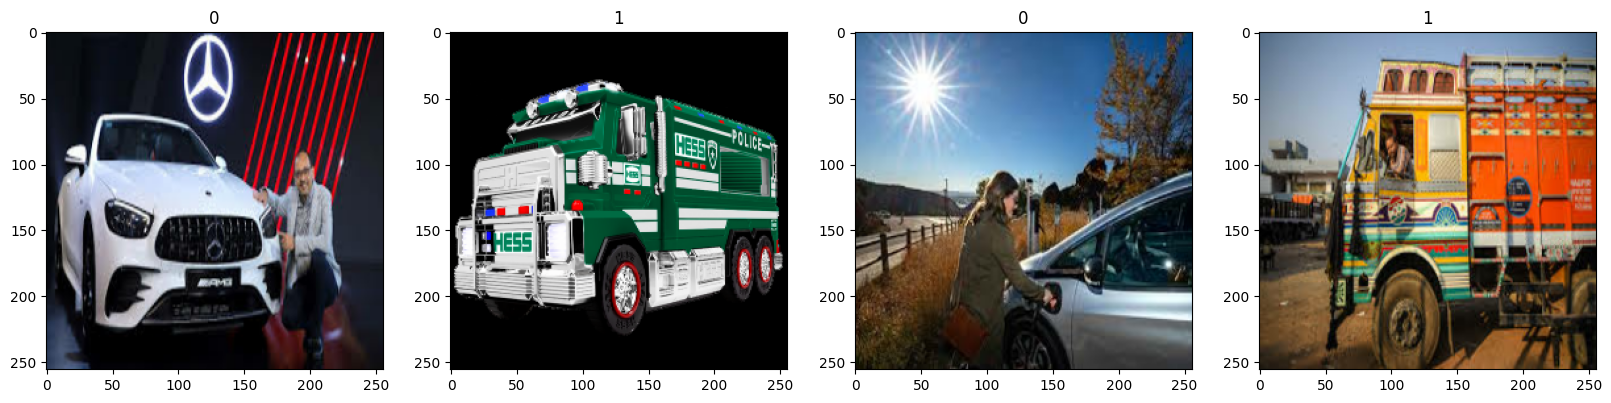

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# Class 1 : Trucks
# Class 0 : Cars

4. Scale Data

In [17]:
# RGB'de değerlendirmeler 0 ile 255 arasında oluyor (min: 0, max: 255) Eğer 255'e bölersek 0 ile 1 arasına alırız. Böylece işlem yükünü azaltmış oluruz.
# Burada map metodu ile değerleri 0 ile 1 arasına alıyoruz.
data = data.map(lambda x,y: (x/255, y))

In [18]:
data.as_numpy_iterator().next()

(array([[[[0.563174  , 0.54748774, 0.54356617],
          [0.5686275 , 0.5529412 , 0.54901963],
          [0.5784773 , 0.56279105, 0.5588695 ],
          ...,
          [0.627451  , 0.7411765 , 0.8117647 ],
          [0.6297947 , 0.7435202 , 0.81410843],
          [0.627451  , 0.7411765 , 0.8117647 ]],
 
         [[0.5661918 , 0.5505055 , 0.54658395],
          [0.57254905, 0.5568628 , 0.5529412 ],
          [0.5803922 , 0.5647059 , 0.56078434],
          ...,
          [0.6313726 , 0.74509805, 0.8156863 ],
          [0.63039213, 0.7441176 , 0.8147059 ],
          [0.6313726 , 0.74509805, 0.8156863 ]],
 
         [[0.5677849 , 0.55209863, 0.54817706],
          [0.56288296, 0.5471967 , 0.5432751 ],
          [0.5764706 , 0.56078434, 0.5568628 ],
          ...,
          [0.63529414, 0.7490196 , 0.81960785],
          [0.6313726 , 0.74509805, 0.8156863 ],
          [0.6313726 , 0.74509805, 0.8156863 ]],
 
         ...,
 
         [[0.7970435 , 0.7499847 , 0.6950827 ],
          [0.78719

5. Split Data

In [19]:
train_size = int(len(data)*.7) # Training için verinin %70'i
val_size = int(len(data)*.2) # Validation için %20'si
test_size = int(len(data)*.1) # Test için %10'u

In [20]:
test_size

1

In [21]:
train = data.take(train_size) # Verisetinin ilk 4 parçasını alıyoruz
val = data.skip(train_size).take(val_size) # Verisetinin ilk 4 parçasını pas geçiyoruz ve sonraki 2 parçasını alıyoruz.
test = data.skip(train_size+val_size).take(test_size) # Verisetinin ilk 4 + 2 kısmını pas geçiyoruz ve sonraki 1 yani son parçasını alıyoruz.

6. Build Deep Learning Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [ ]:
model = Sequential()

In [ ]:
# Input katmanını oluşturuyoruz.
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# Maximum Pooling ile pooling katmanlarını oluşturuyoruz. Bu katmanla, önceki evrişimli katmanın baskın özelliklerini öne çıkartırız.
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
# Flatten katmanı ile filtrelerden elde edilen özellik haritasını tek vektöre çeviriyoruz.
model.add(Flatten())
# Tam bağlı (Dense) katmanını oluşturuyoruz.
model.add(Dense(256, activation='relu'))
# Output katmanı
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Adam optimizasyon algoritmasını kullanacağız.
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

7. Train

In [27]:
logdir='logs'

In [28]:
# Checkpointlerden yararlanmak için faydalı
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
# Eğitimi başlat
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 8s 763ms/step - loss: 1.2144 - accuracy: 0.4866 - val_loss: 0.6965 - val_accuracy: 0.4844
Epoch 2/20
7/7 [==============================] - 6s 711ms/step - loss: 0.6981 - accuracy: 0.5179 - val_loss: 0.6948 - val_accuracy: 0.4844
Epoch 3/20
7/7 [==============================] - 7s 769ms/step - loss: 0.6753 - accuracy: 0.5982 - val_loss: 0.6601 - val_accuracy: 0.6875
Epoch 4/20
7/7 [==============================] - 9s 954ms/step - loss: 0.6569 - accuracy: 0.6607 - val_loss: 0.6317 - val_accuracy: 0.6875
Epoch 5/20
7/7 [==============================] - 8s 806ms/step - loss: 0.6293 - accuracy: 0.6518 - val_loss: 0.5944 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 7s 772ms/step - loss: 0.6258 - accuracy: 0.6473 - val_loss: 0.5931 - val_accuracy: 0.7188
Epoch 7/20
7/7 [==============================] - 7s 718ms/step - loss: 0.5989 - accuracy: 0.6652 - val_loss: 0.5721 - val_accuracy: 0.7969
Epoch 8/20
7/7 [==

8. Plot Performance

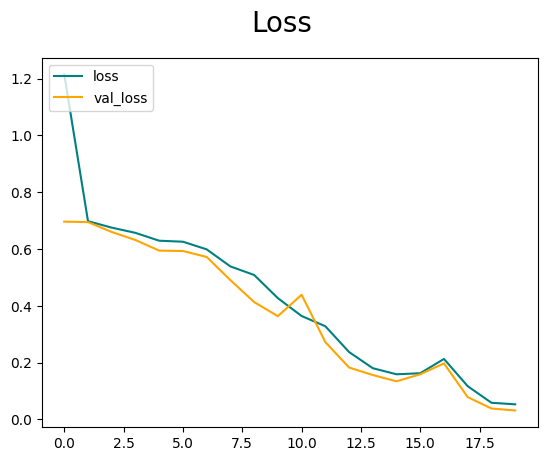

In [30]:
# Loss değerlerinin değişimine dair grafik
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

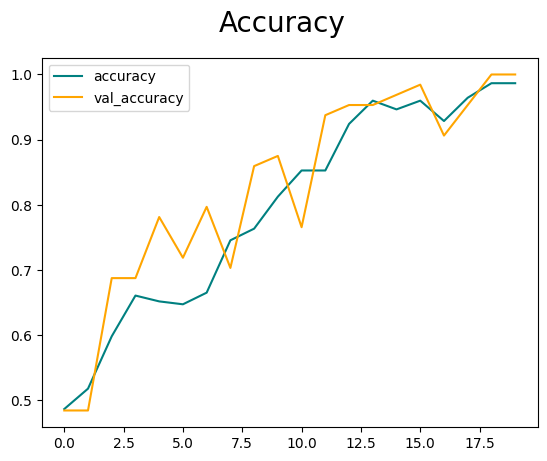

In [31]:
# Doğruluk (Accuracy) değerlerinin değişime dair grafik
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 429ms/step


In [35]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy: 1.0


10. Test

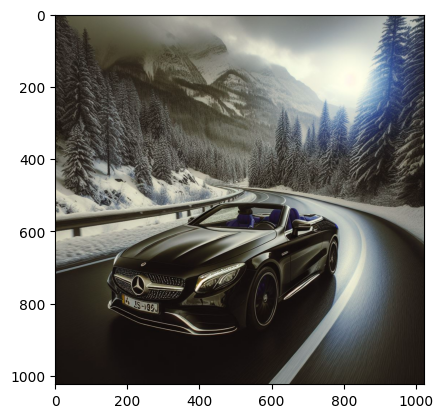

In [36]:
img = cv2.imread('test/car.jpeg')
plt.imshow(img)
plt.show()

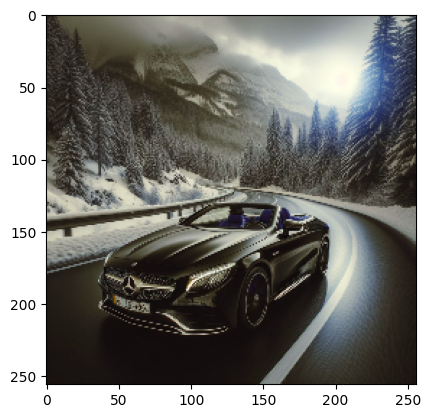

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 149ms/step


In [39]:
yhat

array([[0.94142056]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Car')
else:
    print(f'Predicted class is Truck')

Predicted class is Car


11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','vehicleclassifier.keras'))